## Model setup and training

In [1]:
# In[1]:

import os
import glob
import time
from datetime import timedelta
import cv2
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from dpt.models import DPTDepthModel
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from data.InteriorNetDataset import InteriorNetDataset
from data.metrics import SILog, get_metrics
from util.gpu_config import get_batch_size

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
input_path = 'input'
output_path = 'output_monodepth'
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'
logs_path = 'train-logs'

if k8s:
    input_path = os.path.join(k8s_repo, input_path)
    output_path = os.path.join(k8s_repo, output_path)
    model_path = os.path.join(k8s_pvc, 'dpt-hybrid-nyu.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)
    logs_dir = os.path.join(k8s_pvc, logs_path)
    os.chdir('/')

In [3]:
net_w = 640
net_h = 480

normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

In [4]:
# create dataloader

start = time.time()
    
batch_size = get_batch_size()
lr = 1e-4
num_epochs = 100

print('-- Hyperparams --')
print(f'Batchsize: {batch_size}')
print(f'Learning rate: {lr}')
print(f'Epochs: {num_epochs}')
print('-----------------')

# get shifted statistics

get_new = False

if get_new:
    start = time.time()

    full_dataset = InteriorNetDataset(dataset_path, transform=transform)
    d = []
    p = 0.1
    for i in np.random.choice(len(full_dataset), size=round(p*len(full_dataset)), replace=False):
        d.append(full_dataset[i]['depth'].flatten())

    d = 1 / np.array(d)
    idx = ~np.isnan(d)
    t = np.median(d[idx])
    s = (d[idx] - t).mean()

    print(f'Retrieved statistics in {timedelta(seconds=round(time.time()-start,2))}s')
    print(f's: {s}, t: {t}')

else:
    s, t = 0.4364, 0.4115

-- Hyperparams --
Batchsize: 8
Learning rate: 0.0001
Epochs: 100
-----------------


In [5]:
class InteriorNetDPT(pl.LightningModule):
    def __init__(self, batch_size, lr, num_epochs):
        super().__init__()
        self.model = DPTDepthModel(
                        path=model_path,
                        scale=s,
                        shift=t,
                        invert=True,
                        backbone="vitb_rn50_384",
                        non_negative=True,
                        enable_attention_hooks=False,
                     )
        
        self.model.pretrained.model.patch_embed.requires_grad = False
        self.save_hyperparameters()
            
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['depth']
        yhat = self.model(x)
        loss = SILog(yhat, y)
        self.log('train_loss', loss, on_epoch=True)
        
        metrics = get_metrics(yhat.detach(), y.detach())
        self.log('absrel', metrics[0], on_epoch=True)
        self.log('delta_acc', metrics[1], on_epoch=True)
        self.log('mae', metrics[2], on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), 
                          lr=self.hparams.lr)
    
    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams)
        
    def training_epoch_end(self, _):
        self.logger.log_graph(torch.ones((self.hparams.batch_size, net_h, net_w, 3)))

In [6]:
start = time.time()

# model setup
model = InteriorNetDPT(batch_size, lr, num_epochs)

# logging setup
exp_idx = len(list(filter(lambda f: '.pt' in f, os.listdir(os.path.join(logs_dir)))))
logger = TensorBoardLogger(logs_dir, name='finetune')

# dataloader setup
interiornet_dataset = InteriorNetDataset(dataset_path, transform=transform, subsample=True)
dataloader = DataLoader(interiornet_dataset, 
                        batch_size=model.hparams.batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=4*torch.cuda.device_count() if torch.cuda.is_available() else 0)


print(f'Created datasets in {timedelta(seconds=round(time.time()-start,2))}')

Created datasets in 0:00:27.280000


In [7]:
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        trainer = pl.Trainer(gpus=torch.cuda.device_count(), 
                             max_epochs=model.hparams.num_epochs,
                             accelerator='ddp',
                             logger=logger)
    else:
        trainer = pl.Trainer(gpus=torch.cuda.device_count(), 
                             max_epochs=model.hparams.num_epochs,
                             logger=logger)
else:
    trainer = pl.Trainer(max_epochs=1, logger=logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
print('Training')

start = time.time()
trainer.fit(model, dataloader) #see logs for vnum=6

print(f'Training completed in {timedelta(seconds=round(time.time()-start,2))}')
print(f'Training checkpoints and logs are saved in {trainer.log_dir}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training



  | Name  | Type          | Params
----------------------------------------
0 | model | DPTDepthModel | 123 M 
----------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
492.588   Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Training completed in 0:14:04.720000
Training checkpoints and logs are saved in christh9-pvc/train-logs/finetune/version_3
Final trained weights saved in finetune0.pt


## Model evaluation

In [9]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# compare to original model predictions
original_model = InteriorNetDPT(batch_size, lr, num_epochs)
original_model.to(device)
print('Loaded original model')

Loaded original model


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


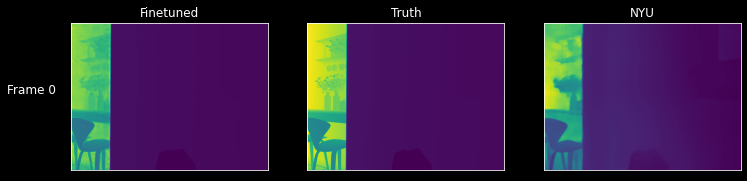

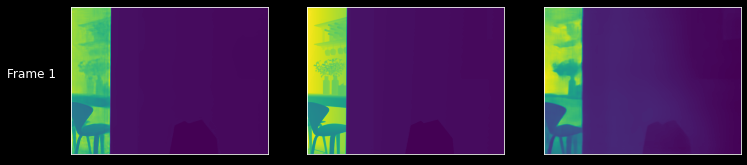

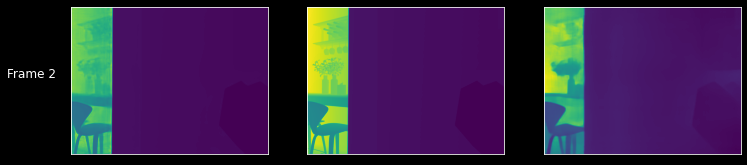

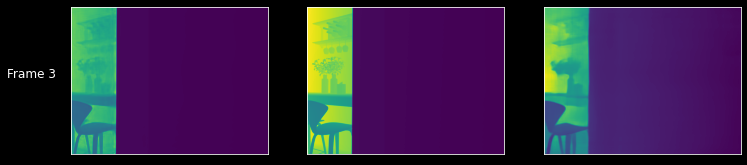

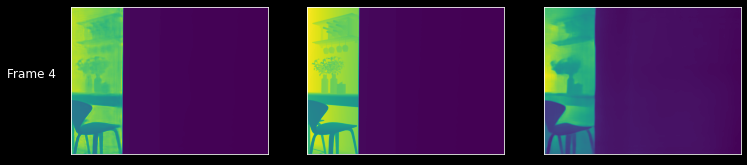

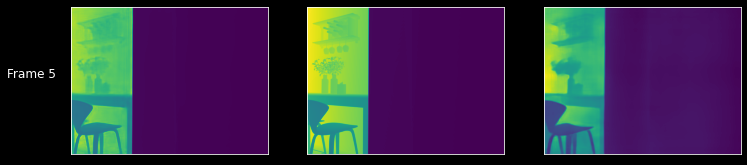

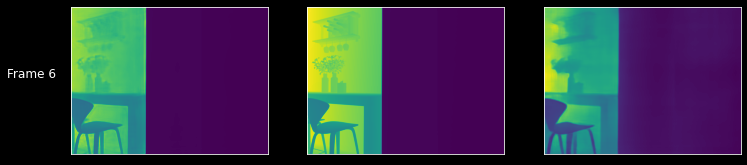

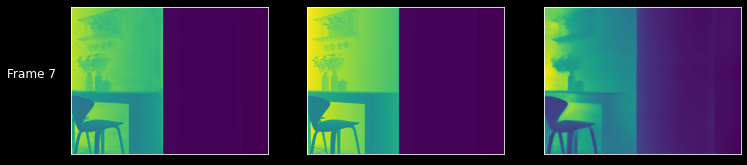

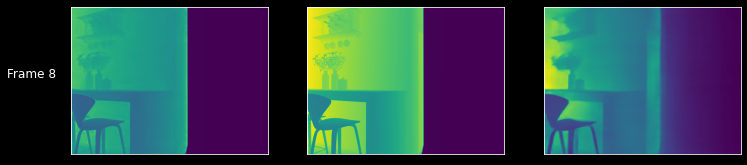

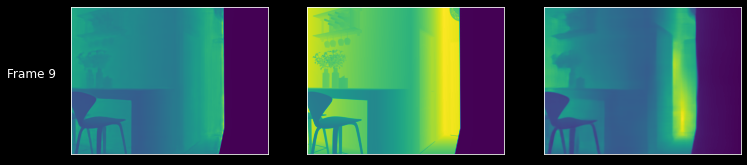

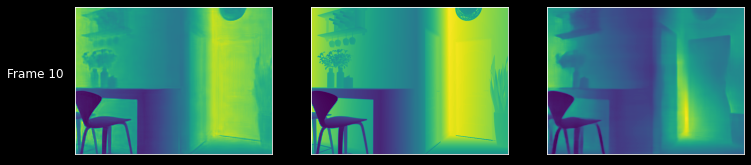

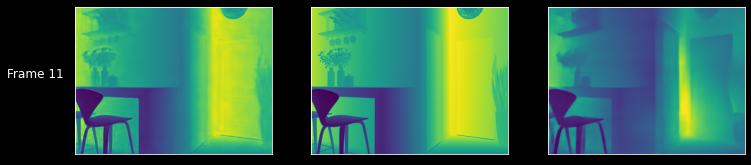

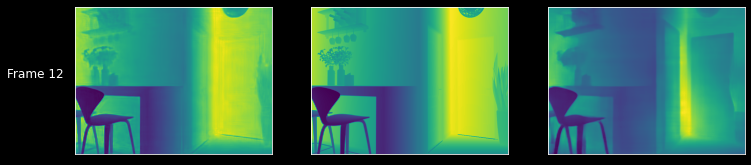

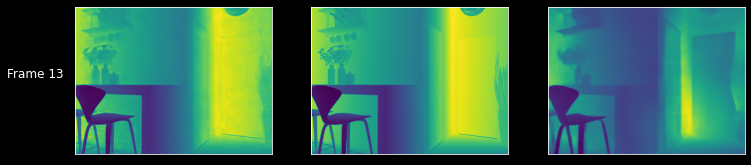

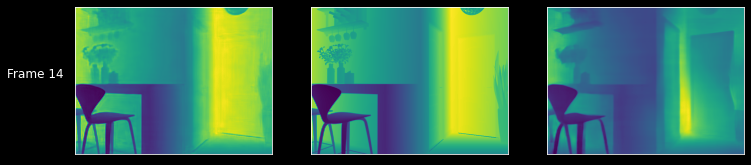

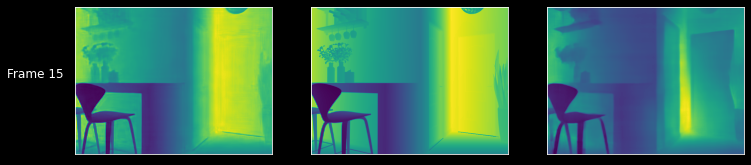

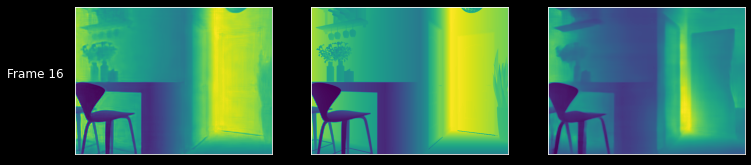

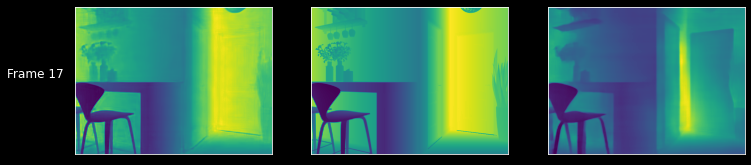

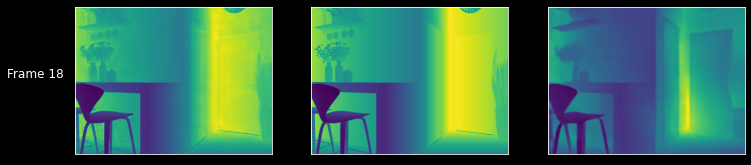

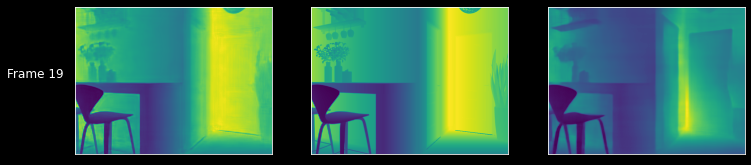

In [11]:
with torch.no_grad():
    num_photos = len(interiornet_dataset)
    for i,sample in enumerate(interiornet_dataset):
        fig = plt.figure(figsize=(12,12))
        
        image, depth = torch.tensor(sample['image']).to(device), sample['depth']
        out = model(image.unsqueeze(0)).squeeze(0).to('cpu')
        out_nyu = original_model(image.unsqueeze(0)).squeeze(0).to('cpu')
        
        for j,img in enumerate([out, depth, out_nyu]):
            ax = fig.add_subplot(1,3,j+1)
            if j == 0:
                ax.set_ylabel(f'Frame {i}', rotation=0, size='large')
            ax.imshow(img)
            
            ax.yaxis.set_label_coords(-0.2, 0.5)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
        
        if i == 0:
            for ax,name in zip(fig.axes,['Finetuned', 'Truth', 'NYU']):
                ax.set_title(name)
                
        fig.show()
        
        if i >= num_photos - 1: break
        i += 1
        
plt.show()